# Рекомендация тарифов

В вашем распоряжении данные о поведении клиентов, которые уже перешли на эти тарифы (из проекта курса «Статистический анализ данных»). Нужно построить модель для задачи классификации, которая выберет подходящий тариф. Предобработка данных не понадобится — вы её уже сделали.

Постройте модель с максимально большим значением *accuracy*. Чтобы сдать проект успешно, нужно довести долю правильных ответов по крайней мере до 0.75. Проверьте *accuracy* на тестовой выборке самостоятельно.

## Откройте и изучите файл

In [ ]:
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.dummy import DummyClassifier

In [ ]:
df = pd.read_csv('/content/users_behavior.csv')
df

,calls,minutes,messages,mb_used,is_ultra
0,40.0,311.90,83.0,19915.42,0
1,85.0,516.75,56.0,22696.96,0
2,77.0,467.66,86.0,21060.45,0
3,106.0,745.53,81.0,8437.39,1
4,66.0,418.74,1.0,14502.75,0
...,...,...,...,...,...
3209,122.0,910.98,20.0,35124.90,1
3210,25.0,190.36,0.0,3275.61,0
3211,97.0,634.44,70.0,13974.06,0
3212,64.0,462.32,90.0,31239.78,0


Выведем таблицу на экран, проверим есть ли пропуски в data frame

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3214 entries, 0 to 3213
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   calls     3214 non-null   float64
 1   minutes   3214 non-null   float64
 2   messages  3214 non-null   float64
 3   mb_used   3214 non-null   float64
 4   is_ultra  3214 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 125.7 KB


In [ ]:
report = df.isna().sum().to_frame()
report = report.rename(columns={0: 'missing_values'})
report['% of total'] = (report['missing_values'] / df.shape[0]).round(2)
report.sort_values(by='missing_values', ascending=False)

,missing_values,% of total
calls,0,0.0
minutes,0,0.0
messages,0,0.0
mb_used,0,0.0
is_ultra,0,0.0


Мы отметили, что пропуски отсутствуют, можем переходить к изучению моделей

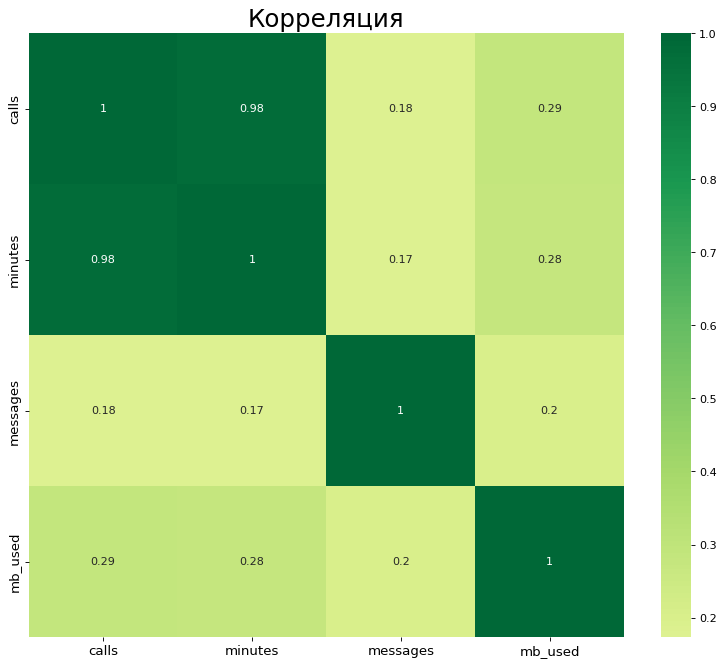

In [ ]:
plt.figure(figsize=(12,10), dpi=80)
sns.heatmap(
    df[['calls','minutes','messages','mb_used']].corr(), 
    xticklabels=df[['calls','minutes','messages','mb_used']].corr().columns,
    yticklabels=df[['calls','minutes','messages','mb_used']].corr().columns, 
    cmap='RdYlGn', center=0, annot=True
    )

plt.title('Корреляция', fontsize=22)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

## Разбейте данные на выборки

Первоначально разобьем таблицу на 3 выборки: тренерующую, валидационную, тестовую: 60/20/20.

In [ ]:
train_tariff_data, valid_tariff_data = train_test_split(
    df, test_size=0.4, random_state=42
    )

valid_tariff_data, test_tariff_data = train_test_split(
    valid_tariff_data, test_size=0.5, random_state=42
    )

print('Размер тренировочной выборки', train_tariff_data.shape[0])
print('Размер валидационной выборки', valid_tariff_data.shape[0])
print('Размер тестовой выборки', test_tariff_data.shape[0])

Размер тренировочной выборки 1928
Размер валидационной выборки 643
Размер тестовой выборки 643


Модель будет обучена на тренировочной выборке (train_tariff_data)
Валидация модели пройдет на валидационной выборке (valid_tariff_data)
После этого проверим работу моделей на тестовой выборке (test_tariff_data)

## Исследуйте модели

Исследуем качество разных моделей (Случайный лес, Решающий лес). 

In [ ]:
train_features = train_tariff_data.drop(['is_ultra', 'minutes'], axis=1)
train_target = train_tariff_data['is_ultra']

valid_features = valid_tariff_data.drop(['is_ultra', 'minutes'], axis=1)
valid_target = valid_tariff_data['is_ultra']

test_features = test_tariff_data.drop(['is_ultra', 'minutes'], axis=1)
test_target = test_tariff_data['is_ultra']

Выделим целевой признак в каждой выборке: в нашем случае это столбец "is_ultra"

Начнем с модели "Случайный лес". Попробуем найти лучшую accuracy. 

In [ ]:
best_est = 0
best_accuracy = 0

for est in range(1,50):
    model = RandomForestClassifier(random_state=42, n_estimators=est)
    model.fit(train_features, train_target)
    valid_predictions = model.predict(valid_features)
    accuracy = accuracy_score(valid_target, valid_predictions)

    if accuracy > best_accuracy:
        best_est = est
        best_accuracy = accuracy

print('Количество деревьев', best_est,'Лучшая точность', best_accuracy)
print()
model

Количество деревьев 38 Лучшая точность 0.8102643856920684



RandomForestClassifier(n_estimators=49, random_state=42)

Перейдем к моделе "Решающего леса"

In [ ]:
best_depth = 0
best_accuracy = 0

for depth in range(1,30):
    model_2 = DecisionTreeClassifier(random_state=42, max_depth=depth)
    model_2.fit(train_features, train_target)
    valid_predictions = model_2.predict(valid_features)
    accuracy = accuracy_score(valid_target, valid_predictions)
    
    if accuracy > best_accuracy:
        best_depth = depth
        best_accuracy = accuracy

print('Лучшая глубина дерева', best_depth,'Лучшая точность на валидационной выборке', best_accuracy)
print()
model_2

Лучшая глубина дерева 8 Лучшая точность на валидационной выборке 0.8133748055987559



DecisionTreeClassifier(max_depth=29, random_state=42)

Модель "Решающего леса" показала себя хуже, попробуем улучшить ее. Из библиотеки нашли дополнительный параметр, который можно поменять: criterion = "entropy" (до этого по умолчанию стоял "gini")

In [ ]:
best_tree_model = DecisionTreeClassifier(random_state=42, max_depth=8, criterion='entropy')
best_tree_model.fit(train_features, train_target)
valid_predictions = best_tree_model.predict(valid_features)
accuracy = accuracy_score(valid_target, valid_predictions)
print('Глубина дерева', 8,'Точность',accuracy)

Глубина дерева 8 Точность 0.8009331259720062


Изменений в лучшую сторону не произошло, оставляем критерий gini

В ходе исследования мы получили следующие результаты:

1) Accuracy модели решающего дерева при глубине 8 равна 0.796.


2) Accuracy модели случайного леса при количестве деревьев 38 равна 0.799. 

Мы видим, что разницы в Accuracy почти нет, начнем переходить к тестовой выборке.


## Проверьте модель на тестовой выборке

In [ ]:
%%time
best_tree_model = DecisionTreeClassifier(random_state=42, max_depth=8, criterion='gini')
best_tree_model.fit(train_features, train_target)
test_predictions = best_tree_model.predict(test_features)
accuracy = accuracy_score(test_target, test_predictions)
print('Accuracy модели решающего леса на тестовой выборке',accuracy)

Accuracy модели решающего леса на тестовой выборке 0.7931570762052877
CPU times: user 11 ms, sys: 2.06 ms, total: 13 ms
Wall time: 12.1 ms


In [ ]:
%%time
best_random_model = RandomForestClassifier(random_state=42, n_estimators=38) 
best_random_model.fit(train_features, train_target)
test_predictions_1 = best_random_model.predict(test_features)
accuracy_1 = accuracy_score(test_target, test_predictions_1)
print('Accuracy модели случайного леса на тестовой выборке',accuracy_1)

Accuracy модели случайного леса на тестовой выборке 0.8195956454121306
CPU times: user 151 ms, sys: 1.86 ms, total: 153 ms
Wall time: 153 ms


Обе модели показали Accuracy более 0.75. Кроме того, мы добавили функцию для определения времени. Accuracy модели "Случайного леса" выше (Accuracy составила 0.811), однако по затраченному времени побеждает модель "Решающего дерева". 

## (бонус) Проверьте модели на адекватность

Для того, чтобы проверить нашу лучшую модель Случайного леса на адекватность, сравним ее со случайной моделью (DummyClassifier)

In [ ]:
%%time
dummy_model = DummyClassifier(random_state=42)
dummy_model.fit(train_features, train_target)
dummy_predictions = dummy_model.predict(test_features)
accuracy_2 = accuracy_score(test_target, dummy_predictions)
print('Accuracy случайной модели на тестовой выборке',accuracy_2)

Accuracy случайной модели на тестовой выборке 0.6967340590979783
CPU times: user 3.78 ms, sys: 50 µs, total: 3.83 ms
Wall time: 3.53 ms


Случайная модель показала результат хуже чем наша(0.58 против 0.81), можем заявить, что наша модель предсказывет лучше.

<div class="alert alert-block alert-info">
По поводу  most_frequent': правильно ли я понял, что здесь необходимо использовать функцию def most_frequent(List):? Нашел в документации только ее.

In [ ]:
strategies = ['stratified', 'most_frequent', 'uniform']
  
dummy_results = []
for strategy in strategies: 
    dc = DummyClassifier(strategy=strategy, random_state=42)
    
    dc.fit(train_features, train_target) 
    result = dc.score(test_features, test_target)
    dummy_results.append({strategy: result})

pd.DataFrame(dummy_results)

,stratified,most_frequent,uniform
0,0.584759,NaN,NaN
1,NaN,0.696734,NaN
2,NaN,NaN,0.510109


## Чек-лист готовности проекта

Поставьте 'x' в выполненных пунктах. Далее нажмите Shift+Enter.

- [x] Jupyter Notebook открыт
- [x] Весь код исполняется без ошибок
- [x] Ячейки с кодом расположены в порядке исполнения
- [x] Выполнено задание 1: данные загружены и изучены
- [x] Выполнено задание 2: данные разбиты на три выборки
- [x] Выполнено задание 3: проведено исследование моделей
    - [x] Рассмотрено больше одной модели
    - [x] Рассмотрено хотя бы 3 значения гипепараметров для какой-нибудь модели
    - [x] Написаны выводы по результатам исследования
- [x] Выполнено задание 3: Проведено тестирование
- [x] Удалось достичь accuracy не меньше 0.75


ВЫВОД


В данном проекте мы изучили данные, разбили их на три части: обучающую, валидационную и тестовую. После этого было проведено исследование с 2 моделями: Решающее дерево, Случайный лес. Для каждой модели мы нашли подходящие параметры. После этого обе модели использовали для тестовой выборки. Accuracy обеих моделей показала результаты выше требуемых(0.75). Сравнив параметр Accuracy, мы отдали предпочтение модели "Случайный лес". В конце мы также проверили нашу модель на адекватность, сравнив ее Acccuracy с Acccuracy случайной модели.

